In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import esda
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 

from pysal.lib import weights
from splot.libpysal import plot_spatial_weights

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":


'1.1.2'

In [2]:
filename = "data/20-04-23.csv"

In [3]:
#df = pd.read_csv(filename, names=["id", "rooms", "area", "rent", "street", "zip_code", "latitude", "longitude"], skiprows=1)
df = pd.read_csv(filename, names=["id", "rooms", "area", "rent", "latitude", "longitude"], skiprows=1)

In [4]:
df.columns

Index(['id', 'rooms', 'area', 'rent', 'latitude', 'longitude'], dtype='object')

# Data anomalities

In [5]:
# Drop 0 latitude / longitude:
df.drop(df[df.latitude == 0].index, inplace=True)
df.drop(df[df.longitude == 0].index, inplace=True)

In [6]:
# Uniqueness
duplicates = df.duplicated(subset=['id'])
duplicates_df = df[duplicates]

In [7]:
# Get number of duplicates
duplicates.value_counts()

False    2012
dtype: int64

In [8]:
df["id"].value_counts()

5248131    1
5015733    1
4568229    1
4766655    1
5015702    1
          ..
5239371    1
5174258    1
5239413    1
4821327    1
5092256    1
Name: id, Length: 2012, dtype: int64

In [9]:
# Display the duplicates - Note: They are not necessarily duplicates as street/door numnber is not included.
#duplicates_df.sort_values(by=['street', 'area'])
df.sort_values(by=['id'])

,id,rooms,area,rent,latitude,longitude
1931,1503813,1,77,45000,55.705974,12.588295
1198,1503814,2,77,55000,55.705974,12.588295
1332,1503815,1,60,40000,55.706086,12.588568
898,2116616,3,119,14950,55.620511,12.573563
1275,2391595,3,102,13600,55.620789,12.571120
...,...,...,...,...,...,...
1153,5275901,1,37,5632,55.707792,12.485342
33,5275914,5,160,23000,55.676226,12.541370
1077,5275951,4,115,19000,55.669016,12.512669
1061,5275968,3,146,26000,55.737286,12.538268


In [10]:
# Get number of nan values per columns
for col in df.columns:
    print(col)
    print(df[col].isnull().values.sum())

id
0
rooms
0
area
0
rent
0
latitude
0
longitude
0


In [11]:
# Dataframe with nans dropped
df2 = df.dropna()

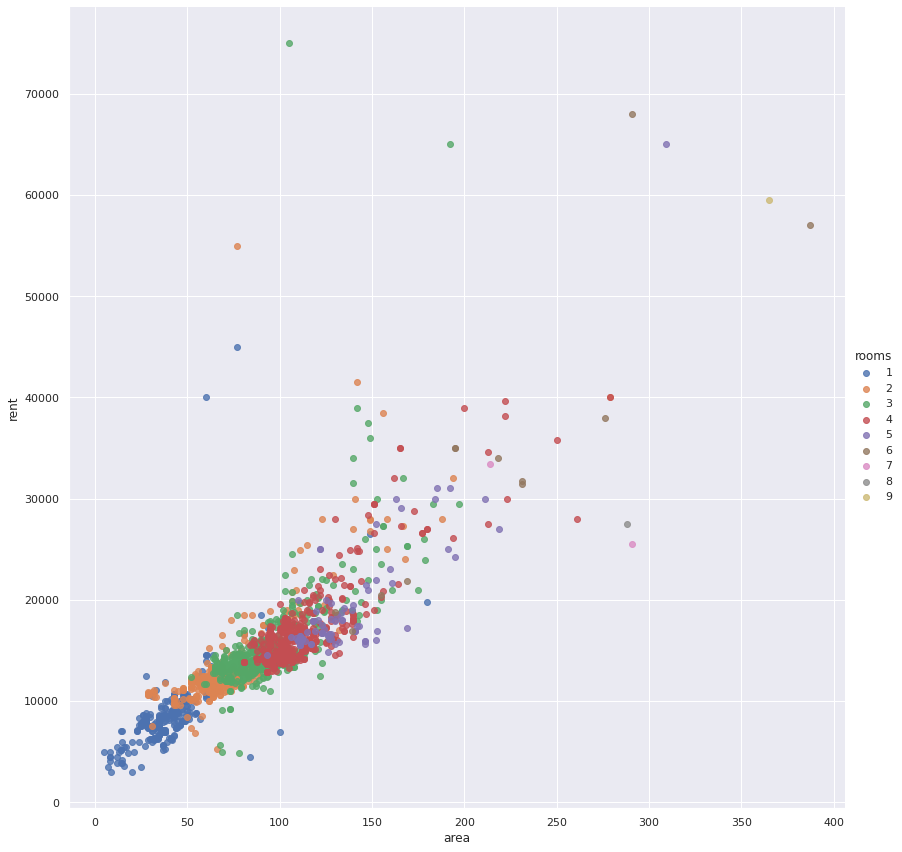

In [12]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()

# Data wrangling (normalize)

In [13]:
df2["rent_norm"] = df2["rent"] / df2["area"]

In [14]:
df2

,id,rooms,area,rent,latitude,longitude,rent_norm
0,5248131,1,38,5216,55.652406,12.512200,137.263158
1,5275700,1,37,7900,55.671065,12.501394,213.513514
2,5211187,1,40,6300,55.649554,12.551497,157.500000
3,5263181,3,73,11000,55.663465,12.542260,150.684932
4,5249720,3,73,11000,55.663465,12.542260,150.684932
...,...,...,...,...,...,...,...
2013,5149586,3,93,13500,55.677018,12.435548,145.161290
2014,5023178,3,156,27300,55.672170,12.589605,175.000000
2015,5115263,2,85,13300,55.676449,12.436417,156.470588
2016,4953591,3,85,13000,55.676449,12.436417,152.941176


In [15]:
# Saving the file with added norm column
df2.to_csv(filename.split(".")[0] + "_norm" + ".csv")

# Geopandas

In [16]:
#geometry = gdp.points_from_xy(df2.longitude, df2.latitude, crs="EPSG:4326")
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude,df2.latitude, crs="EPSG:4326"))

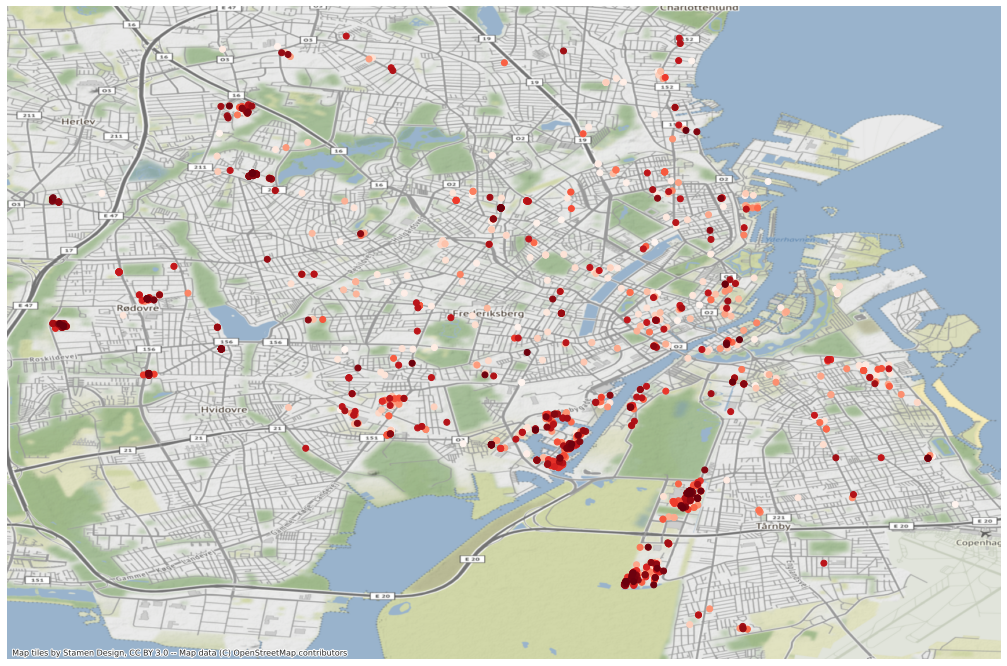

In [17]:
ax = gdf.plot(c=gdf["rent"], cmap='Reds', legend=True) #color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')

# City Areas

In [18]:
cph_areas_bydel = gpd.read_file("data/bydel.geojson")

In [19]:
cph_areas_bydel

,id,bydel_nr,navn,areal_m2,ogc_fid,geometry
0,3,3,Nørrebro,4107620.0,1,"MULTIPOLYGON (((12.53704 55.69653, 12.53694 55..."
1,30,6,Vanløse,6699013.0,2,"MULTIPOLYGON (((12.49820 55.68552, 12.49845 55..."
2,32,7,Brønshøj-Husum,8740777.0,3,"MULTIPOLYGON (((12.46894 55.69975, 12.46935 55..."
3,10,10,Amager Vest,19364766.0,4,"MULTIPOLYGON (((12.58271 55.66850, 12.58252 55..."
4,2,2,Østerbro,9858727.0,5,"MULTIPOLYGON (((12.59777 55.70348, 12.59700 55..."
5,4,4,Vesterbro-Kongens Enghave,8327301.0,6,"MULTIPOLYGON (((12.54553 55.63972, 12.54677 55..."
6,31,5,Valby,9235110.0,7,"MULTIPOLYGON (((12.52434 55.66666, 12.52372 55..."
7,8,8,Bispebjerg,6830452.0,8,"MULTIPOLYGON (((12.53830 55.72644, 12.53822 55..."
8,9,9,Amager Øst,9800687.0,9,"MULTIPOLYGON (((12.63082 55.67057, 12.63079 55..."
9,1,1,Indre By,10471990.0,10,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."


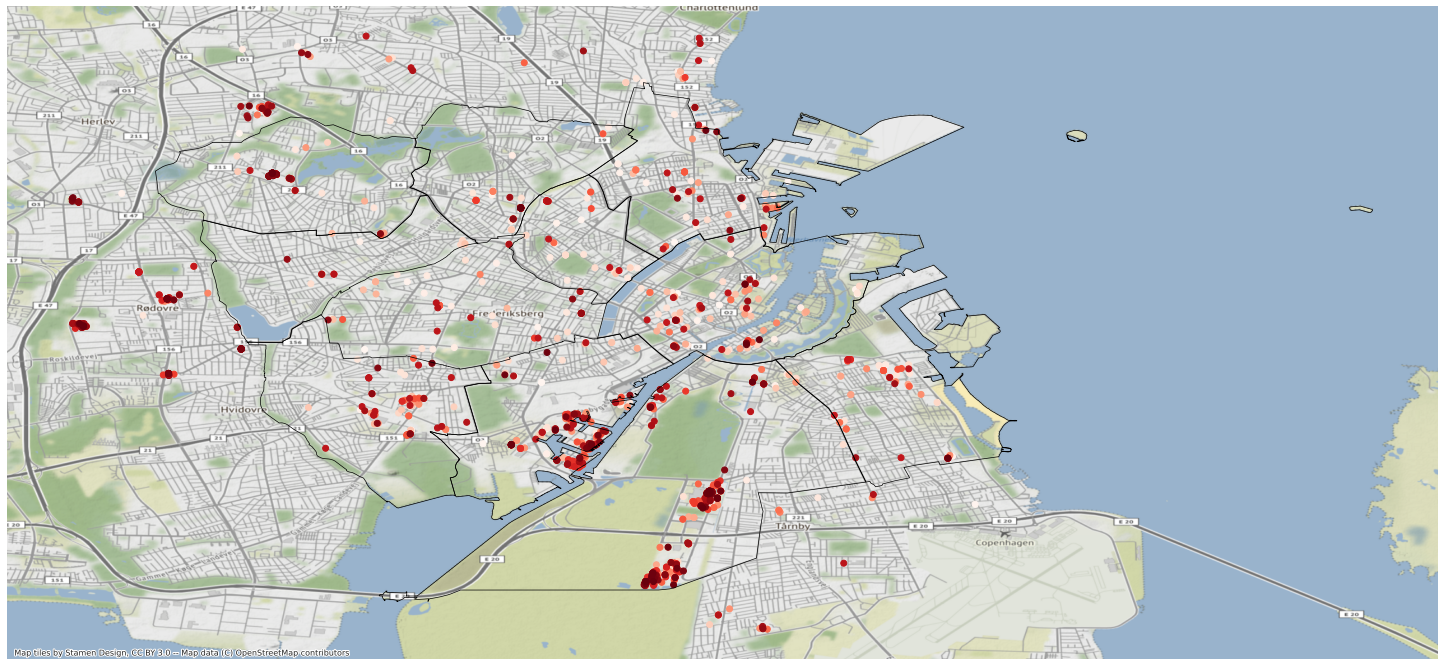

In [20]:
ax = gdf.plot(c=gdf["rent_norm"], cmap='Reds', legend=True) #color="black")
ax2 = cph_areas_bydel.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')

# Spatial Weights

### Block weights

In [21]:
joined = gpd.sjoin(gdf,cph_areas_bydel,how='left',op='within')

In [22]:
# Removing nan columns
joined_clean = joined.dropna(subset = ['index_right']).set_index('id_left')

In [23]:
joined_clean.head()

,rooms,area,rent,latitude,longitude,rent_norm,geometry,index_right,id_right,bydel_nr,navn,areal_m2,ogc_fid
id_left,,,,,,,,,,,,,
5248131,1,38,5216,55.652406,12.512200,137.263158,POINT (12.51220 55.65241),6.0,31.0,5.0,Valby,9235110.0,7
5211187,1,40,6300,55.649554,12.551497,157.500000,POINT (12.55150 55.64955),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6
5263181,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6
5249720,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6
5142344,3,95,11000,55.695855,12.572995,115.789474,POINT (12.57300 55.69586),4.0,2.0,2.0,Østerbro,9858727.0,5


In [24]:
w_block = weights.block_weights(joined_clean['index_right'])

In [25]:
w_block.remap_ids(joined_clean.index)

In [27]:
# Row-based transformation
w_block.transform = 'R'

### Kernel weights

In [73]:
# With fixed distance band
#w_kernel = weights.distance.Kernel.from_dataframe(gdf, function='gaussian')

In [74]:
#w_kernel.remap_ids(gdf.index)

In [75]:
#w_kernel.bandwidth[0:5]

In [76]:
# Row-based transformation
#w_kernel.transform = 'R'

In [77]:
# With adaptive distance band
w_adaptive = weights.distance.Kernel.from_dataframe(
    gdf, fixed=False, k=15, function='gaussian'
)

In [78]:
w_adaptive.remap_ids(gdf.index)

In [79]:
w_adaptive.bandwidth[0:5]

array([[0.000894  ],
       [0.01036372],
       [0.00101599],
       [0.00994554],
       [0.00994554]])

# Global spatial autocorrelation

## Block

In [32]:
# Non standardized spatial lag
joined_clean['w_rent_norm'] = weights.lag_spatial(w_block, joined_clean['rent_norm']) # we pass the weights object and the column with values to base the spatial lag on

In [33]:
joined_clean['rent_norm_std'] = (
    joined_clean['rent_norm'] - joined_clean['rent_norm'].mean()
) / joined_clean['rent_norm'].std()

In [34]:
joined_clean['w_rent_norm_std'] = weights.lag_spatial(w_block, joined_clean['rent_norm_std'])

In [35]:
joined_clean.head()

,rooms,area,rent,latitude,longitude,rent_norm,geometry,index_right,id_right,bydel_nr,navn,areal_m2,ogc_fid,w_rent_norm,rent_norm_std,w_rent_norm_std
id_left,,,,,,,,,,,,,,,,
5248131,1,38,5216,55.652406,12.512200,137.263158,POINT (12.51220 55.65241),6.0,31.0,5.0,Valby,9235110.0,7,186.394875,-0.768931,0.132997
5211187,1,40,6300,55.649554,12.551497,157.500000,POINT (12.55150 55.64955),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6,167.620619,-0.397436,-0.211649
5263181,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6,167.649620,-0.522543,-0.211116
5249720,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6,167.649620,-0.522543,-0.211116
5142344,3,95,11000,55.695855,12.572995,115.789474,POINT (12.57300 55.69586),4.0,2.0,2.0,Østerbro,9858727.0,5,222.080762,-1.163131,0.788095


In [36]:
joined_clean[joined_clean["index_right"] == "Valby"]

,rooms,area,rent,latitude,longitude,rent_norm,geometry,index_right,id_right,bydel_nr,navn,areal_m2,ogc_fid,w_rent_norm,rent_norm_std,w_rent_norm_std
id_left,,,,,,,,,,,,,,,,


## Adaptive kernel

In [80]:
gdf['rent_norm_std'] = (
    gdf['rent_norm'] - gdf['rent_norm'].mean()
) / gdf['rent_norm'].std()

In [81]:
gdf['w_rent_norm_std'] = weights.lag_spatial(w_adaptive, gdf['rent_norm_std'])

## Moran Plot

### Block

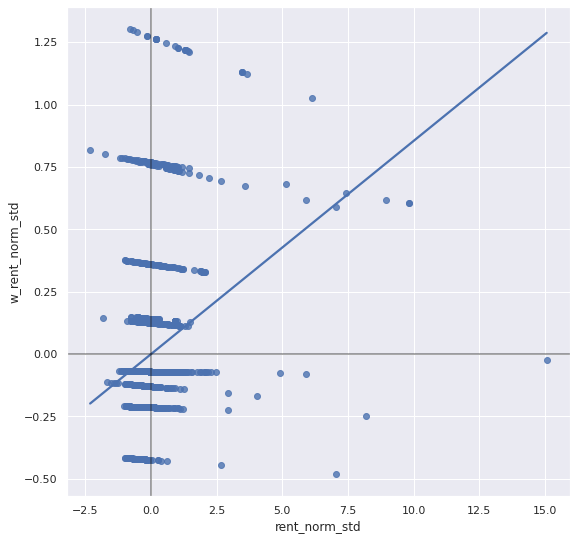

In [37]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='rent_norm_std', y='w_rent_norm_std', data=joined_clean, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

### Adaptive kernel

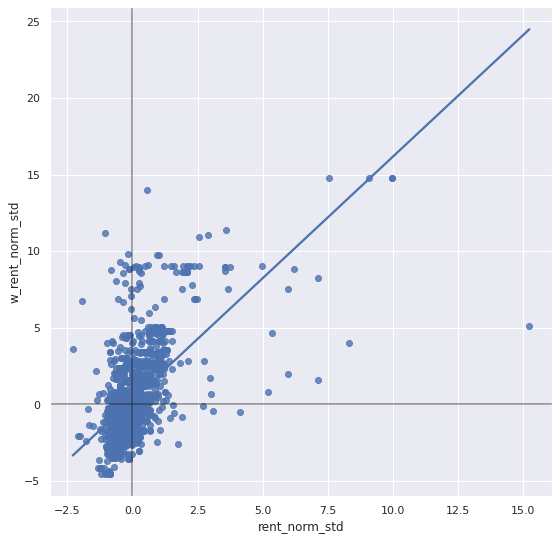

In [82]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='rent_norm_std', y='w_rent_norm_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

## Moran's I

### Block

In [38]:
mi = esda.Moran(joined_clean['rent_norm'], w_block)

In [39]:
mi.I

0.08547464587715389

In [40]:
mi.p_sim

0.001

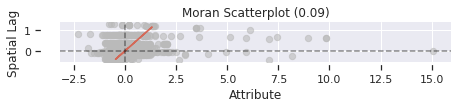

In [41]:
moran_scatterplot(mi);

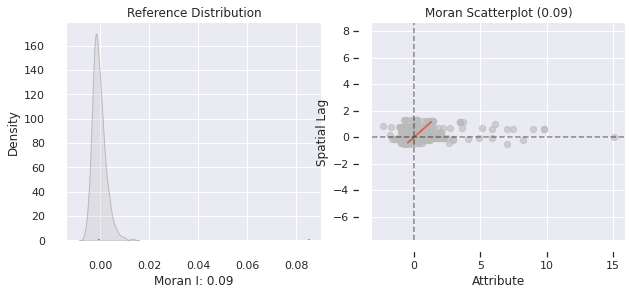

In [42]:
plot_moran(mi);

### Adaptive kernel

In [83]:
mi = esda.Moran(gdf['rent_norm'], w_adaptive)

In [84]:
mi.I, mi.p_sim

(nan, 0.001)

Exception: one or more input arrays have missing/NaN values

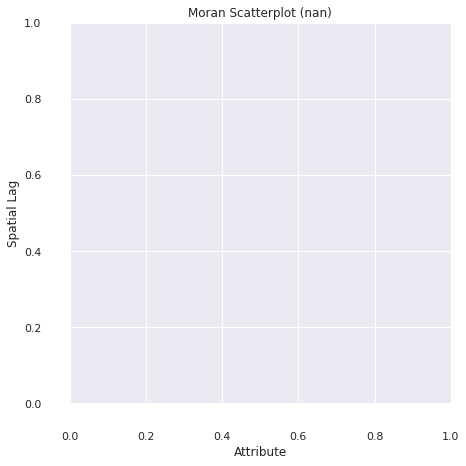

In [85]:
moran_scatterplot(mi);

In [ ]:
plot_moran(mi);